<div style="text-align: center;font-size: 90%;">
<img src="inpe-grande.png" align="center" width=200/>
</div>

<div style="text-align: left;">
    <a href="https://nbviewer.jupyter.org/github/brazil-data-cube/code-gallery/blob/master/jupyter/Python/stac/stac-introduction.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" align="center"/></a>
</div>


<br/>
<div style="text-align: center;font-size: 300%;">
<span style="text-align: center; color:#ff3300">Burned Areas in Scenes</span>
</div>
<hr style="border:2px inset #ff9900 ;">

<br/>

<div style="text-align: center;font-size: 90%;color: #cccc00">
    <a href='https://github.com/danielfarkat'>Daniel Farkat<img src='gitnew.png'width=20/></a>
    <br/>
    <a href='mailto:daniel.farkat@inpe.br'>daniel.farkat@inpe.br</a> 
    <br/><br/>
    Applied Computing Division, National Institute for Space Research (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Last Update: Nov 28, 2024
    
</div>


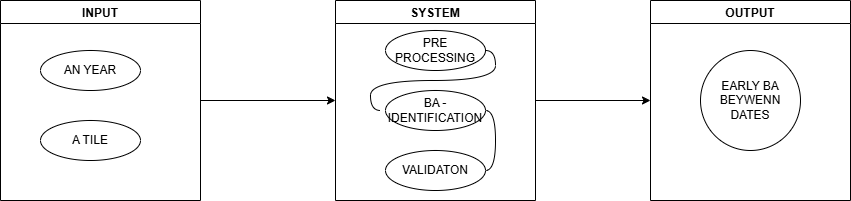

<h1 style="text-align: center;font-size: 300;color: #ff3300">
SUMMARY
</h1>



**PRE-PROCESSING**

- Needed imports  

- Search Filter
 
- Requests files 

- duplicate analysis

- List of files atribute table 

- Require CRS, Transforms, Bonds and Image

- Generete bbox for firespots

**BURNED AREAS IDENTIFICATION**

- use SCL diference 

- Generate dNBR SWIR mask 

**Validation**

- import Firespots in the bbox 

- Firespot intersect with ba_mask

- JSON response



<h1 style="text-align: center;font-size: 300;color: #ff3300">
PRE-PROCESSING
</h1>

<hr style="border:2px inset #ff9900 ;">

<h1 style="font-size: 150;color: #ff3300">
NEEDED IMPORTS
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
All the needed imports will be parsed bellow for future access
</div>

## FOR IMAGE PROCESSING

In [11]:
# Bibliotecas padrão
import xml.etree.ElementTree as ET  # Para trabalhar com XML
from urllib.request import urlretrieve
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

# Bibliotecas de geometria e geoprocessamento
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from pyproj import Proj, Transformer, transform
from datetime import datetime, timedelta
# Bibliotecas externas específicas
import rasterio
import pystac_client
import folium
# Biblioteca interna (customizada)
import early_ba_detection  # -> Nome da biblioteca que foi criada'

from rasterio.features import shapes
from shapely.geometry import shape
%matplotlib inline

import numpy as np
import rasterio
from matplotlib import pyplot as plt
from pyproj import Transformer
from pyproj.crs import CRS
from rasterio.windows import bounds, from_bounds, Window
from pyproj import CRS
from rasterio.features import rasterize

# versions = {
#     "geopandas": gpd.__version__,
#     "requests": requests.__version__,
#     "pandas": pd.__version__,
#     "numpy": np.__version__,
#     "shapely": shapely.__version__,
#     "lxml": lxml.__version__,
#     "tqdm": tqdm.__version__
# }

## FOR FIRE-SPOTS


In [12]:
import geopandas as gpd
import requests
import pandas as pd
import numpy as np
import shapely
import lxml
import xml.etree.ElementTree as ET
import tqdm
versions = {
    "geopandas": gpd.__version__,
    "requests": requests.__version__,
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "shapely": shapely.__version__,
    "lxml": lxml.__version__,
    "tqdm": tqdm.__version__
}
from tqdm import tqdm
from shapely import Point

versions

{'geopandas': '1.0.1',
 'requests': '2.32.3',
 'pandas': '2.2.3',
 'numpy': '2.1.3',
 'shapely': '2.0.6',
 'lxml': '5.3.0',
 'tqdm': '4.67.1'}

<h1 style="font-size: 150 ;color: #ff3300">
SEARCH_FILTER
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLATE INFO
</div>

In [ ]:
## FILTERS
start_date = "2022-01-01"
end_date = "2022-12-30"
tile='22LHH'
cloud_porcentage=50

<h1 style="font-size: 150 ;color: #ff3300">
REQUESTS FILES
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLATE INFO
</div>

In [ ]:
catalog_url = 'https://data.inpe.br/bdc/stac/v1/'
client = pystac_client.Client.open(catalog_url) # access the service
search = client.search(
    collections=['S2_L2A-1'],  # Colection name
    datetime=f"{start_date}/{end_date}",  # Filtro por data  
    query={"bdc:tiles":{'in':[f'{tile}']}, 'eo:cloud_cover':{"lt":cloud_porcentage}},
    sortby=[{
        'field': 'properties.datetime',
        'direction': 'asc'
    }],
    limit=100  # we do need to limitate to pass from an amount that is possible to be proccessed in real time
)

<h1 style="font-size: 150 ;color: #ff3300">
DUPLICATE ANALYSIS
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLATE INFO
</div>

In [ ]:
itens = list(search.get_all_items())
i = 0
for item in itens:
    
    if i >=1:
        if itens[i-1].datetime.date() == itens[i].datetime.date():
            print(f'date iqual {itens[i-1].datetime} e {itens[i].datetime}' )
            print(f'arquivo {itens[i-1].id} e {itens[i].id}' )
            print(f"arquivo {itens[i-1].assets['PVI'].href}" )
            print(f"arquivo {itens[i].assets['PVI'].href}" )
        if itens[i-2].datetime.date() == itens[i-1].datetime.date():
                    print(f'arquivo {itens[i-1].datetime} e {itens[i-2].datetime}' )        
    i+=1

# exemple of two images at the same day

## image 1
<hr style="border:2px inset #ff9900">

![image.png](https://data.inpe.br/bdc/data/S2_L2A/v001/22/L/HH/2022/07/S2B_PVI_20220706T133149_N0400_R081_T22LHH_20220706T155133.png)

## image 2
<hr style="border:2px inset #ff9900">

![image-2.png](https://data.inpe.br/bdc/data/S2_L2A/v001/22/L/HH/2022/07/S2B_PVI_20220706T133149_N0400_R081_T22LHH_20220706T172430.png)

<h1 style="font-size: 150 ;color: #ff3300">
LIST OF FILES ATRIBUTE TABLE
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLATE INFO
</div>

In [ ]:
dates_after = []
dates_before = []
item_after = []
item_before = []
href_b8a_after = []
href_b8a_before = []
href_b11_after = []
href_b11_before = []
href_b12_after = []
href_b12_before = []
href_scl_after = []
href_scl_before = []
k=-1
for i in range(1, len(itens)):
    current_item = itens[i]
    prev_item = itens[i - 1]
    if current_item.datetime.date() != prev_item.datetime.date():
        # Comparação com o item anterior
        reference_item = prev_item
        # print(itens[i].datetime.date(),itens[i-1].datetime.date())
        if k==-1:
            if prev_item.datetime.date() != itens[i-2].datetime.date():
                k=-1
            else:
                i-=1
                k+=1
        else:
            prev_item=itens[i-2]
            k=-1
    if current_item.datetime.date() == prev_item.datetime.date():
        # Comparação com o item dois passos atrás
        reference_item = itens[i - 2]
        if k==-1:
            if reference_item.datetime.date() != itens[i-3].datetime.date():
                k=-1
            else:
                i-=1
                k+=1
        else:
            prev_item=itens[i-3].datetime.date()
            k=-1
        # print(itens[i].datetime.date(),itens[i-2].datetime.date())

    # Adicionando dados das datas
    dates_after.append(current_item.datetime.date())
    dates_before.append(reference_item.datetime.date())

    # Adicionando IDs
    item_after.append(current_item.id)
    item_before.append(reference_item.id)

    # Adicionando links
    href_b8a_after.append(current_item.assets['B8A'].href)
    href_b8a_before.append(reference_item.assets['B8A'].href)

    href_b11_after.append(current_item.assets['B11'].href)
    href_b11_before.append(reference_item.assets['B11'].href)

    href_b12_after.append(current_item.assets['B12'].href)
    href_b12_before.append(reference_item.assets['B12'].href)

    href_scl_after.append(current_item.assets['SCL'].href)
    href_scl_before.append(reference_item.assets['SCL'].href)

data_dict = {
    'dates_before': dates_before,
    'dates_after': dates_after,
    'item_before': item_before,
    'item_after': item_after,
    'href_b8a_before': href_b8a_before,
    'href_b8a_after': href_b8a_after,
    'href_b11_before': href_b11_before,
    'href_b11_after': href_b11_after,
    'href_b12_before': href_b12_before,
    'href_b12_after': href_b12_after,
    'href_scl_before': href_scl_before,
    'href_scl_after': href_scl_after
}

df = pd.DataFrame(data_dict)

df


<h1 style="font-size: 150 ;color: #ff3300">
Require CRS, Transforms, Bonds and Image
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLATE INFO
</div>

In [ ]:
df.iloc[76,]

asset_exemple = 76
scl_before=df.iloc[asset_exemple,10]
scl_after=df.iloc[asset_exemple,11]
href_b12_before=df.iloc[asset_exemple,8]
href_b12_after=df.iloc[asset_exemple,9]
href_b11_before=df.iloc[asset_exemple,6]
href_b11_after=df.iloc[asset_exemple,7]
href_b8a_before=df.iloc[asset_exemple,4]
href_b8a_after=df.iloc[asset_exemple,5]

## Read Tiff as a function 

Get the informations as transformes, bounds and crs aboutn

In [ ]:
def read_tiff_image(file_path):
    with rasterio.open(file_path) as src:
        image_data = src.read(1) 
        transform = src.transform  
        crs = src.crs  
        bounds = src.bounds 
    return image_data, transform, crs, bounds



# Exemple analysis 

In [ ]:
tiff_scl_before = read_tiff_image(scl_before)
bounds = tiff_scl_before[3]
crs = tiff_scl_before[2]
crs = CRS.from_wkt(f'{crs}')
epsg_code = crs.to_epsg()
epsg_code

In [ ]:
bounds

<h1 style="font-size: 150 ;color: #ff3300">
Generete bbox for firespots
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
Transformando os limites para EPSG:4326 (WGS84)
</br>
Imprimindo a BBOX no formato WGS84
</div>

In [ ]:

crs_original = CRS.from_epsg(epsg_code)  
crs_destino = CRS.from_epsg(4326)

# Transformando os limites para o EPSG:4326
bounds_4326 = rasterio.warp.transform_bounds(crs_original, crs_destino, 
                                bounds.left, bounds.bottom, 
                                bounds.right, bounds.top)

# Resultado no formato de BBOX
bbox_4326 = {
    "minx": bounds_4326[0],  # Longitude mínima
    "miny": bounds_4326[1],  # Latitude mínima
    "maxx": bounds_4326[2],  # Longitude máxima
    "maxy": bounds_4326[3],  # Latitude máxima
}

## The tile

The tile represented in wgs-84 is  presented bellow

In [ ]:
print(f"BBOX EPSG:4326: {bbox_4326}")

<h1 style="text-align: center;font-size: 300;color: #ff3300">
BURNED AREAS IDENTIFICATION
</h1>

<hr style="border:2px inset #ff9900 ;">

<h1 style="font-size: 150;color: #ff3300">
use SCL diference
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
Create the function to generate the diference berwen two scl images
</div>

In [ ]:
def calculate_dscl(scl_path_before,scl_path_after):
    scl_data_before, transform, crs, scl_bounds_before = read_tiff_image(scl_path_before)
    scl_data_after, _, _, scl_bounds_after = read_tiff_image(scl_path_after)

    scl_mask_before = np.isin(scl_data_before, [4, 5])  
    scl_mask_after = np.isin(scl_data_after, [4, 5])

    scl_before = np.where (scl_mask_before, 1, np.nan)
    scl_after = np.where (scl_mask_after, 1, np.nan)
    dscl = scl_before*scl_after

    return dscl, transform, crs, scl_before,scl_after

In [ ]:
dscl, transform, crs, scl_before,scl_after = calculate_dscl(scl_before,scl_after)

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(scl_before, cmap='grey')

ax2.imshow(scl_after, cmap='grey')

ax3.imshow(dscl, cmap='grey')


<h1 style="font-size: 150 ;color: #ff3300">
GENERATE DNBR SWIR MASK
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLATE INFO
</div>

In [13]:
def calculate_dscl(scl_path_before,scl_path_after):
    scl_data_before, transform, crs, scl_bounds_before,bbox_4326 = read_tiff_image(scl_path_before)
    scl_data_after, _, _, scl_bounds_after,bbox_4326 = read_tiff_image(scl_path_after)

    scl_mask_before = np.isin(scl_data_before, [4, 5])  
    scl_mask_after = np.isin(scl_data_after, [4, 5])

    scl_before = np.where (scl_mask_before, 1, np.nan)
    scl_after = np.where (scl_mask_after, 1, np.nan)
    dscl = scl_before*scl_after

    return dscl, transform, crs,bbox_4326

In [14]:
def generate_data_frame(year,tile='22LHH',cloud_porcentage=50):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-30"
    catalog_url = 'https://data.inpe.br/bdc/stac/v1/'
    client = pystac_client.Client.open(catalog_url) # access the service
    search = client.search(
        collections=['S2_L2A-1'],  # Colection name
        datetime=f"{start_date}/{end_date}",  # Filtro por data  
        query={"bdc:tiles":{'in':[f'{tile}']}, 'eo:cloud_cover':{"lt":cloud_porcentage}},
        sortby=[{
            'field': 'properties.datetime',
            'direction': 'asc'
        }],
        limit=100  # we do need to limitate to pass from an amount that is possible to be proccessed in real time
    )
    itens = list(search.get_all_items())
    dates_after = []
    dates_before = []
    item_after = []
    item_before = []
    href_b8a_after = []
    href_b8a_before = []
    href_b11_after = []
    href_b11_before = []
    href_b12_after = []
    href_b12_before = []
    href_scl_after = []
    href_scl_before = []
    k=-1
    for i in range(1, len(itens)):
        current_item = itens[i]
        prev_item = itens[i - 1]
        if current_item.datetime.date() != prev_item.datetime.date():
            # Comparação com o item anterior
            reference_item = prev_item
            # print(itens[i].datetime.date(),itens[i-1].datetime.date())
            if k==-1:
                if prev_item.datetime.date() != itens[i-2].datetime.date():
                    k=-1
                else:
                    i-=1
                    k+=1
            else:
                prev_item=itens[i-2]
                k=-1
        if current_item.datetime.date() == prev_item.datetime.date():
            # Comparação com o item dois passos atrás
            reference_item = itens[i - 2]
            if k==-1:
                if reference_item.datetime.date() != itens[i-3].datetime.date():
                    k=-1
                else:
                    i-=1
                    k+=1
            else:
                prev_item=itens[i-3].datetime.date()
                k=-1
            # print(itens[i].datetime.date(),itens[i-2].datetime.date())

        # Adicionando dados das datas
        dates_after.append(current_item.datetime.date())
        dates_before.append(reference_item.datetime.date())

        # Adicionando IDs
        item_after.append(current_item.id)
        item_before.append(reference_item.id)

        # Adicionando links
        href_b8a_after.append(current_item.assets['B8A'].href)
        href_b8a_before.append(reference_item.assets['B8A'].href)

        href_b11_after.append(current_item.assets['B11'].href)
        href_b11_before.append(reference_item.assets['B11'].href)

        href_b12_after.append(current_item.assets['B12'].href)
        href_b12_before.append(reference_item.assets['B12'].href)

        href_scl_after.append(current_item.assets['SCL'].href)
        href_scl_before.append(reference_item.assets['SCL'].href)

    data_dict = {
        'dates_before': dates_before,
        'dates_after': dates_after,
        'item_before': item_before,
        'item_after': item_after,
        'href_b8a_before': href_b8a_before,
        'href_b8a_after': href_b8a_after,
        'href_b11_before': href_b11_before,
        'href_b11_after': href_b11_after,
        'href_b12_before': href_b12_before,
        'href_b12_after': href_b12_after,
        'href_scl_before': href_scl_before,
        'href_scl_after': href_scl_after
    }

    df = pd.DataFrame(data_dict)

    return df


In [15]:
def read_tiff_image(file_path):
    with rasterio.open(file_path) as src:
        image_data = src.read(1) 
        transform = src.transform  
        crs = src.crs  
        bounds = src.bounds 
        epsg_code = crs.to_epsg()
        crs_original = CRS.from_epsg(epsg_code)  
        crs_destino = CRS.from_epsg(4326)

        # Transformando os limites para o EPSG:4326
        bounds_4326 = rasterio.warp.transform_bounds(crs_original, crs_destino, 
                                        bounds.left, bounds.bottom, 
                                        bounds.right, bounds.top)
        
        # Resultado no formato de BBOX
        bbox_4326 = {
            "minx": bounds_4326[0],  # Longitude mínima
            "miny": bounds_4326[1],  # Latitude mínima
            "maxx": bounds_4326[2],  # Longitude máxima
            "maxy": bounds_4326[3],  # Latitude máxima
        }   
    return image_data, transform, crs, bounds,bbox_4326

In [16]:
def genereta_nbr_and_nbr_swir(ddscl_mask, NIR2_path,SWIR2_path,SWIR1_path):
    NIR2_data, transform, crs, NIR2_bounds,bbox_4326 = read_tiff_image(NIR2_path)
    SWIR2_data, _, _, SWIR2_bounds,bbox_4326 = read_tiff_image(SWIR2_path)
    SWIR1_data, _, _, SWIR1_bounds,bbox_4326 = read_tiff_image(SWIR1_path)
    ddscl_mask=np.isin(ddscl_mask, [1])
    NIR2_data = np.where (ddscl_mask, np.array(NIR2_data, dtype=np.float32), np.nan)
    SWIR1_data = np.where (ddscl_mask, np.array(SWIR1_data, dtype=np.float32), np.nan)
    SWIR2_data = np.where (ddscl_mask, np.array(SWIR2_data, dtype=np.float32), np.nan)

    nbr = np.where(ddscl_mask, (NIR2_data - SWIR2_data) / (NIR2_data + SWIR2_data + 1e-20), np.nan) # this is as well a normalization
    nbr_swir = np.where(ddscl_mask, (SWIR1_data - SWIR2_data - 0.02) / (SWIR1_data + SWIR2_data + 1e-20 + 0.1), np.nan)
    return nbr, nbr_swir,bbox_4326

In [17]:
def dnbr_and_dnbr_swir(dscl,ref_b8a_before,href_b11_before,href_b12_before,ref_b8a_after,href_b11_after,href_b12_after):

    nbr_before, nbr_swir_before,bbox_4326 = genereta_nbr_and_nbr_swir(dscl,ref_b8a_before,href_b11_before,href_b12_before)
    nbr_after, nbr_swir_after,bbox_4326 = genereta_nbr_and_nbr_swir(dscl,ref_b8a_after,href_b11_after,href_b12_after)

    dnbr_swir = (nbr_swir_before -nbr_swir_after)/np.abs(nbr_swir_before+ 1e-20)
    dnbr = (nbr_before -nbr_after)/np.abs(nbr_before+1e-20)
    
    dnbr_swir_mask = np.zeros_like(dnbr_swir)
    dnbr_swir_mask[dnbr_swir < 1] =1 
    dnbr_swir_mask[dnbr_swir > 0.3] = 1  # Alta severidade
    dnbr_swir_mask[dnbr_swir <= 0.3] = np.nan  # Sem mudança
    dnbr_mask = np.zeros_like(dnbr) 
    dnbr_mask[dnbr > 0.2] = 1  # Alta severidade
    dnbr_mask[dnbr <= 0.2] = np.nan  # Sem mudança

    return dnbr_mask, dnbr_swir_mask,bbox_4326

In [18]:
df = generate_data_frame(year= '2022',tile='22LHH',cloud_porcentage=50)
asset_exemple = 76
scl_before=df.iloc[asset_exemple,10]
scl_after=df.iloc[asset_exemple,11]
href_b12_before=df.iloc[asset_exemple,8]
href_b12_after=df.iloc[asset_exemple,9]
href_b11_before=df.iloc[asset_exemple,6]
href_b11_after=df.iloc[asset_exemple,7]
href_b8a_before=df.iloc[asset_exemple,4]
href_b8a_after=df.iloc[asset_exemple,5]
item_before=df.iloc[asset_exemple,2]
item_after=df.iloc[asset_exemple,3]
dates_before=df.iloc[asset_exemple,0]
dates_after=df.iloc[asset_exemple,1]

dscl, transform, crs_original,bbox_4326 = calculate_dscl(scl_before,scl_after)
dnbr_mask, dnbr_swir_mask,bbox_4326 = dnbr_and_dnbr_swir(dscl,href_b8a_before,href_b11_before,href_b12_before,href_b8a_after,href_b11_after,href_b12_after)


/home/queimadas/miniconda3/envs/bdclab/lib/python3.10/site-packages/pystac_client/item_search.py:903: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


In [ ]:
plt.imshow(dscl)

In [ ]:
print("scl_before:", scl_before)
print("scl_after:", scl_after)
print("href_b12_before:", href_b12_before)
print("href_b12_after:", href_b12_after)
print("href_b11_before:", href_b11_before)
print("href_b11_after:", href_b11_after)
print("href_b8a_before:", href_b8a_before)
print("href_b8a_after:", href_b8a_after)

In [ ]:
# Calcular histogramas
hist_dnbr, bins_dnbr = np.histogram(dnbr_mask, bins=50, range=(0, 1))  # 50 bins no intervalo [0, 1]
hist_dnbr_swir, bins_dnbr_swir = np.histogram(dnbr_swir_mask, bins=50, range=(0, 1))

# Plotar imagens e histogramas
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Imagem 1
axes[0, 0].imshow(dnbr_mask, cmap='hot')
axes[0, 0].set_title("DNBR Mask")

# Histograma 1
axes[1, 0].bar(bins_dnbr[:-1], hist_dnbr, width=np.diff(bins_dnbr), edgecolor="black", align="edge")
axes[1, 0].set_title("Histogram of DNBR Mask")
axes[1, 0].set_xlabel("Pixel Value")
axes[1, 0].set_ylabel("Frequency")

# Imagem 2
axes[0, 1].imshow(dnbr_swir_mask, cmap='hot')
axes[0, 1].set_title("DNBR SWIR Mask")

# Histograma 2
axes[1, 1].bar(bins_dnbr_swir[:-1], hist_dnbr_swir, width=np.diff(bins_dnbr_swir), edgecolor="black", align="edge")
axes[1, 1].set_title("Histogram of DNBR SWIR Mask")
axes[1, 1].set_xlabel("Pixel Value")
axes[1, 1].set_ylabel("Frequency")

# Ajustar layout
plt.tight_layout()
plt.show()


<h1 style="text-align: center;font-size: 300;color: #ff3300">
VALIDATION
</h1>

<hr style="border:2px inset #ff9900 ;">

<h1 style="font-size: 150;color: #ff3300">
IMPORT FIRE-SPOTS IN THE BBOX 
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLELE INFO
</div>

In [ ]:
def cluster_fire_spots(bbox_4326, year='2024', first_month='09', first_day='10', second_month='09', second_day='15'):
    """
    # Cluster Fire Spots Function

    This function, `cluster_fire_spots`, retrieves and analyzes fire spot data from the TerraBrasilis database (INPE - Brazilian National Institute for Space Research).

    ## Overview:
    The function retrieves fire spot data within a specified bounding box and date range. It queries the TerraBrasilis WFS (Web Feature Service) API for data on fire occurrences (called "focos") based on latitude, longitude, and timestamp.

    ## Parameters:
    - `bbox` (tuple): 
        - A tuple containing the bounding box coordinates in the form (lat_min, lon_min, lat_max, lon_max).
    - `year` (str): The year to filter the fire spots (default: `'2024'`).
    - `first_month` (str): The first month of the date range to filter fire spots (default: `'09'`).
    - `first_day` (str): The first day of the date range to filter fire spots (default: `'10'`).
    - `second_month` (str): The second month of the date range to filter fire spots (default: `'09'`).
    - `second_day` (str): The second day of the date range to filter fire spots (default: `'15'`).

    ## Returns:
    - A GeoDataFrame containing the fire spot data, including coordinates (latitude and longitude) and the corresponding timestamp of each fire occurrence.
    - The function also saves the resulting data as a GeoPackage file (`focosat_bbox.gpkg`).

    ## Usage Example:
    ```python
    bbox = (-10.0, -60.0, -5.0, -55.0)
    gdf = cluster_fire_spots(bbox, year='2023', first_month='01', first_day='01', second_month='01', second_day='15')
    print(gdf.head())
    """
    # Extracting boundaries from the bounding box
    try:
        lon_min = bbox_4326['minx']
        lat_min = bbox_4326['miny']
        lon_max = bbox_4326['maxx']
        lat_max = bbox_4326['maxy']
        print("Processing bounding box for boundaries...")
        print(f"Latitude mínima: {lat_min}")
        print(f"Longitude mínima: {lon_min}")
        print(f"Latitude máxima: {lat_max}")
        print(f"Longitude máxima: {lon_max}")

        # Retrieve fire spot data based on the provided bbox
        gdf = print_points(lat_min, lon_min, lat_max, lon_max, year, first_month, first_day, second_month, second_day)
        return gdf

    except Exception as e:
        print(f"Error: {e}")
        return False


def print_points(lat_min, lon_min, lat_max, lon_max, year, first_month, first_day, second_month, second_day):
    # Generating request URL
    path = f"https://terrabrasilis.dpi.inpe.br/queimadas/geoserver/wfs?SERVICE=WFS&REQUEST=GetFeature&VERSION=2.0.0&TYPENAMES=bdqueimadas3:focos&TYPENAME=bdqueimadas3:focos&SRSNAME=urn:ogc:def:crs:EPSG::4326&CQL_FILTER=data_hora_gmt%20between%20{year}-{first_month}-{first_day}T00%3A00%3A00%20and%20{year}-{second_month}-{second_day}T23%3A59%3A59%20AND%20longitude%20%3E%20{lon_min}%20AND%20longitude%20%3C%20{lon_max}%20AND%20latitude%20%3E%20{lat_min}%20AND%20latitude%20%3C%20{lat_max}"
    print("Fetching data from TerraBrasilis...")
    
    with tqdm(total=100, desc="Downloading Data") as pbar:
        response = requests.get(path)
        pbar.update(100)
    
    lat, lon, date = [], [], []
    xml_data = response.content
    root = ET.fromstring(xml_data)
    namespaces = {
        'wfs': 'http://www.opengis.net/wfs/2.0',
        'gml': 'http://www.opengis.net/gml/3.2',
        'bdqueimadas3': 'https://www.inpe.br/queimadas/bdqueimadas3'
    }

    print("Processing fire spot data...")
    for foco in tqdm(root.findall('.//wfs:member/bdqueimadas3:focos', namespaces), desc="Processing Fire Spots"):
        latitude = foco.find('bdqueimadas3:latitude', namespaces).text
        longitude = foco.find('bdqueimadas3:longitude', namespaces).text
        data_hora = foco.find('bdqueimadas3:data_hora_gmt', namespaces).text
        lat.append(latitude)
        lon.append(longitude)
        date.append(data_hora)

    focos_lat = np.array(lat)
    focos_lon = np.array(lon)
    focos_date = np.array(date)

    print("Creating GeoDataFrame...")
    
    result = list(zip(map(lambda x: float(x), focos_lon), map(lambda x: float(x), focos_lat)))
    d = {'coordinates': result, 'date': focos_date}
    df = pd.DataFrame(data=d)
    df['geometry'] = df['coordinates'].apply(lambda x: Point(x[0], x[1]))
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.crs = {"init": "epsg:4326"}
    return gdf


In [ ]:
year = str(dates_before.year)
first_month = f"{dates_before.month:02d}"  
first_day = f"{dates_before.day:02d}"

year = str(dates_after.year) 
second_month = f"{dates_after.month:02d}" 
second_day = f"{dates_after.day:02d}" 
caminho_arquivo =  bbox_4326

In [ ]:
first_month,first_day,second_month,second_day

In [ ]:
focos = cluster_fire_spots(bbox_4326, year, first_month, first_day, second_month, second_day)

In [ ]:
focos

<h1 style="font-size: 150 ;color: #ff3300">
FIRE-SPOTS INTERSECTS WITH BA-MASK
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLATE INFO
</div>

In [ ]:
focos = focos.to_crs(epsg=f'{crs_original.to_epsg()}')
focos_buffer = focos.buffer(300)

gdf_focos_buffer = gpd.GeoDataFrame(geometry=focos_buffer, crs=focos.crs)

focos_buffer_mask = gdf_focos_buffer.dissolve()

In [ ]:
focos_buffer_mask

In [ ]:
shapes = ((geom, 1,) for geom in focos_buffer_mask.geometry)
focos_buffer_mask_rasterized = rasterize(shapes, out_shape=image.shape, transform=transform)

# Multiplicar a imagem pela máscara rasterizada
image_modified = image * rasterized

In [25]:
import numpy as np
from early_ba_detection_v01 import generate_data_frame,calculate_dscl,dnbr_and_dnbr_swir,cluster_fire_spots
import geopandas as gpd
from rasterio.features import rasterize
# Gera um DataFrame baseado nos parâmetros fornecidos
df = generate_data_frame(year='2022', tile='22LHH', cloud_porcentage=50)

i = 1
if i == 1:
    asset_exemple = 76

    scl_before = df.iloc[asset_exemple, 10]
    scl_after = df.iloc[asset_exemple, 11]
    href_b12_before = df.iloc[asset_exemple, 8]
    href_b12_after = df.iloc[asset_exemple, 9]
    href_b11_before = df.iloc[asset_exemple, 6]
    href_b11_after = df.iloc[asset_exemple, 7]
    href_b8a_before = df.iloc[asset_exemple, 4]
    href_b8a_after = df.iloc[asset_exemple, 5]
    item_before = df.iloc[asset_exemple, 2]
    item_after = df.iloc[asset_exemple, 3]
    dates_before = df.iloc[asset_exemple, 0]
    dates_after = df.iloc[asset_exemple, 1]

    # Calcula dscl e dnbr
    dscl, transform, crs_original, bbox_4326 = calculate_dscl(scl_before, scl_after)
    dnbr_mask, dnbr_swir_mask, bbox_4326 = dnbr_and_dnbr_swir(
        dscl, 
        href_b8a_before, href_b11_before, href_b12_before, 
        href_b8a_after, href_b11_after, href_b12_after
    )

    year = str(dates_before.year)
    first_month = f"{dates_before.month:02d}"  
    first_day = f"{dates_before.day:02d}"

    year = str(dates_after.year) 
    second_month = f"{dates_after.month:02d}" 
    second_day = f"{dates_after.day:02d}" 
    caminho_arquivo =  bbox_4326
    # Gera buffers e máscaras rasterizadas para focos de incêndio
    focos = cluster_fire_spots(bbox_4326, year, first_month, first_day, second_month, second_day)
    focos = focos.to_crs(epsg=f'{crs_original.to_epsg()}')
    focos_buffer = focos.buffer(300)

    gdf_focos_buffer = gpd.GeoDataFrame(geometry=focos_buffer, crs=focos.crs)
    focos_buffer_mask = gdf_focos_buffer.dissolve()
    shapes = ((geom, 1,) for geom in focos_buffer_mask.geometry)
    focos_buffer_mask_rasterized = rasterize(shapes, out_shape=dnbr_swir_mask.shape, transform=transform)

    # Calcula imagem modificada
    image_modified = dnbr_swir_mask * focos_buffer_mask_rasterized

    # Aplica a condição para gerar a máscara final
    image_conditioned = np.where(image_modified == 1, 1, np.nan)
    sum_values = np.nansum(image_conditioned)
    int(sum_values)


/home/queimadas/miniconda3/envs/bdclab/lib/python3.10/site-packages/pystac_client/item_search.py:903: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Processing bounding box for boundaries...
Latitude mínima: -16.350529400566153
Longitude mínima: -48.205922378629374
Latitude máxima: -15.343921467332294
Longitude máxima: -47.165960838884224
Fetching data from TerraBrasilis...


Processing fire spot data...


Processing Fire Spots: 100%|██████████| 1399/1399 [00:00<00:00, 147841.55it/s]
/home/queimadas/miniconda3/envs/bdclab/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Creating GeoDataFrame...


In [26]:
sum_values = np.nansum(image_conditioned)
int(sum_values)

1274

<h1 style="font-size: 150 ;color: #ff3300">
JSON RESPONSE
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLATE INFO
</div>

In [ ]:
import numpy as np
from early_ba_detection_v01 import generate_data_frame,calculate_dscl,dnbr_and_dnbr_swir,cluster_fire_spots
import geopandas as gpd
from rasterio.features import rasterize
# Gera um DataFrame baseado nos parâmetros fornecidos
df = generate_data_frame(year='2022', tile='22LHH', cloud_porcentage=50)
ba_files=[]
day_before_files=[]
day_after_files=[]
item_before_files=[]
item_after_files=[]
i = 1
# if i ==1 :
for i in range(len(df)-1):
    asset_exemple = i+1

    scl_before = df.iloc[asset_exemple, 10]
    scl_after = df.iloc[asset_exemple, 11]
    href_b12_before = df.iloc[asset_exemple, 8]
    href_b12_after = df.iloc[asset_exemple, 9]
    href_b11_before = df.iloc[asset_exemple, 6]
    href_b11_after = df.iloc[asset_exemple, 7]
    href_b8a_before = df.iloc[asset_exemple, 4]
    href_b8a_after = df.iloc[asset_exemple, 5]
    item_before = df.iloc[asset_exemple, 2]
    item_after = df.iloc[asset_exemple, 3]
    dates_before = df.iloc[asset_exemple, 0]
    dates_after = df.iloc[asset_exemple, 1]

    # Calcula dscl e dnbr
    dscl, transform, crs_original, bbox_4326 = calculate_dscl(scl_before, scl_after)
    dnbr_mask, dnbr_swir_mask, bbox_4326 = dnbr_and_dnbr_swir(
        dscl, 
        href_b8a_before, href_b11_before, href_b12_before, 
        href_b8a_after, href_b11_after, href_b12_after
    )

    year = str(dates_before.year)
    first_month = f"{dates_before.month:02d}"  
    first_day = f"{dates_before.day:02d}"

    year = str(dates_after.year) 
    second_month = f"{dates_after.month:02d}" 
    second_day = f"{dates_after.day:02d}" 
    caminho_arquivo =  bbox_4326
    # Gera buffers e máscaras rasterizadas para focos de incêndio
    focos = cluster_fire_spots(bbox_4326, year, first_month, first_day, second_month, second_day)
    focos = focos.to_crs(epsg=f'{crs_original.to_epsg()}')
    focos_buffer = focos.buffer(300)

    gdf_focos_buffer = gpd.GeoDataFrame(geometry=focos_buffer, crs=focos.crs)
    focos_buffer_mask = gdf_focos_buffer.dissolve()
    shapes = ((geom, 1,) for geom in focos_buffer_mask.geometry)
    focos_buffer_mask_rasterized = rasterize(shapes, out_shape=dnbr_swir_mask.shape, transform=transform)

    # Calcula imagem modificada
    image_modified = dnbr_mask*dnbr_swir_mask * focos_buffer_mask_rasterized

    # Aplica a condição para gerar a máscara final
    image_conditioned = np.where(image_modified == 1, 1, np.nan)
    sum_values = np.nansum(image_conditioned)
    pixels_sum=int(sum_values)

#################################################################################################
    file_in_the_df = asset_exemple

    if pixels_sum > 50:
        data_antes = df.iloc[file_in_the_df, 0].strftime('%Y-%m-%d') if isinstance(df.iloc[file_in_the_df, 0], pd.Timestamp) else str(df.iloc[file_in_the_df, 0])
        data_depois = df.iloc[file_in_the_df, 1].strftime('%Y-%m-%d') if isinstance(df.iloc[file_in_the_df, 1], pd.Timestamp) else str(df.iloc[file_in_the_df, 1])
        item_before = df.iloc[file_in_the_df, 2]
        item_after = df.iloc[file_in_the_df, 3]
        ba_detect = 1
        day_before_files.append(data_antes)
        day_after_files.append(data_depois)
        item_before_files.append(item_before)
        item_after_files.append(item_after)
        ba_files.append(ba_detect)
        
        # resultado_df.to_json(f'resultado{asset_exemple}.json', orient='records', lines=False, force_ascii=False, indent=4)
        # print(f"Arquivo 'resultado{asset_exemple}.json' salvo com sucesso!")
    else:
        data_antes = df.iloc[file_in_the_df, 0].strftime('%Y-%m-%d') if isinstance(df.iloc[file_in_the_df, 0], pd.Timestamp) else str(df.iloc[file_in_the_df, 0])
        data_depois = df.iloc[file_in_the_df, 1].strftime('%Y-%m-%d') if isinstance(df.iloc[file_in_the_df, 1], pd.Timestamp) else str(df.iloc[file_in_the_df, 1])
        item_before = df.iloc[file_in_the_df, 2]
        item_after = df.iloc[file_in_the_df, 3]
        ba_detect = 0
        day_before_files.append(data_antes)
        day_after_files.append(data_depois)
        item_before_files.append(item_before)
        item_after_files.append(item_after)
        ba_files.append(ba_detect)
        # resultado_df = pd.DataFrame([{
        #     "data_antes": data_antes,
        #     "data_depois": data_depois,
        #     "item_before": item_before,
        #     "item_after": item_after,
        #     "ba_detect": ba_detect
        # }])
        # resultado_df.to_json(f'resultado{asset_exemple}.json', orient='records', lines=False, force_ascii=False, indent=4)
        # print(f"Arquivo 'resultado{asset_exemple}.json' salvo com sucesso!")
resultado_df = pd.DataFrame([{
        "day_before": day_before_files,
        "day_after": day_after_files,
        "item_before": item_before_files,
        "item_after": item_after_files,
        "ba_detect": ba_files
}])



In [54]:
resultado_df

day_before  \
0  [2022-01-17, 2022-01-19, 2022-01-22, 2022-01-2...   

                                           day_after  \
0  [2022-01-19, 2022-01-22, 2022-01-24, 2022-01-2...   

                                         item_before  \
0  [S2B_MSIL2A_20220117T133219_N0301_R081_T22LHH_...   

                                          item_after  \
0  [S2A_MSIL2A_20220119T132231_N0301_R038_T22LHH_...   

                                           ba_detect  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...
Name: ba_detect, dtype: object